# Term Structure of Interest Rates

_The best thing about the future is that it comes one day at a time_ - Abraham Lincoln

The term structure of interest rates describes how interest rates and bond yields vary across different maturities, typically illustrated using a yield curve. We examine basic concepts such as spot rates, forward rates, par rates, and yield-to-maturity, along with techniques for modeling the term structure, including yield curve construction, splines, and bootstrapping. To gain intuitive insights into the dynamics of interest rate movements, we also apply low-rank approximation methods such as Principal Component Analysis (PCA) and Singular Value Decomposition (SVD).

In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import re
from typing import List, Dict
from datetime import datetime
import numpy as np
import numpy.linalg as la
from scipy.interpolate import CubicSpline
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from finds.readers import Alfred
from secret import credentials, paths
VERBOSE = 0
# %matplotlib qt

In [2]:
alf = Alfred(api_key=credentials['fred']['api_key'], convert_date=0, verbose=VERBOSE)

## Interest Rates

The frequency at which interest is compounded determines how an interest rate is measured. For example, an annual compounding rate assumes interest is compounded once per year, while a semi-annual compounding rate assumes two compounding periods per year. 

The **Annualized Percentage Yield (APY)** or **effective annual yield** accounts for the effects of compounding. The conversion formula is:

$$
APY = \left(1 + \frac{R_m}{m} \right)^m - 1
$$

where $ m $ represents the number of compounding periods per year.

To convert an interest rate $R_m$ with compounding frequency $ m $ to an equivalent **continuously compounded rate** $r$, we use the formula:  

$$
e^{rt} = \left(1 + \frac{R_m}{m} \right)^{mt}
$$

The **spot rate** for a given maturity is the zero-coupon rate applicable to that period. It is directly related to the discount factor:

$$
\text{Discount factor} = \left(1 + \frac{R_m}{m} \right)^{-t}
$$

The **forward rate** is the implied future interest rate derived from observed spot rates. Longer-term spot rates can be determined by compounding forward rates.

A bond’s **yield to maturity (YTM)** is the single discount rate that equates the bond’s present value of cash flows to its market price.

The **par rate** is the coupon rate at which a bond is issued at par value. A bond priced at par has a yield to maturity equal to its coupon rate.

The **term structure of interest rates** represents the relationship between yields and maturities. When plotted, it forms a **yield curve**. An upward-sloping curve indicates that forward rates are higher than spot and par rates, while a downward-sloping curve suggests the opposite.

**Swap rates** represent fixed interest rates exchanged for floating rates in an interest rate swap and are considered par rates.




In [3]:
# retrieve Constant Maturity Treasuries, excluding inflation-indexed and discontinued
cat = alf.get_category(115)  # Fed H.15 Selected Interest Rates
print('Retrieved category:', cat['id'], cat['name'])

Retrieved category: 115 Treasury Constant Maturity


In [4]:
treas = DataFrame.from_dict(
    {s['id']: [s['observation_start'], s['frequency'], s['title'].split(',')[0][44:]]
     for s in cat['series'] if 'Inflation' not in s['title'] and
     'DISCONT' not in s['title'] and s['frequency'] in ['Daily', 'Monthly']},
    columns = ['start', 'freq', 'title'],
    orient='index').sort_values(['freq', 'start'])
print("Constant Maturity Treasuries in FRED")
pd.set_option('display.max_colwidth', None)
treas

Constant Maturity Treasuries in FRED


,start,freq,title
DGS1,1962-01-02,Daily,1-Year Constant Maturity
DGS10,1962-01-02,Daily,10-Year Constant Maturity
DGS20,1962-01-02,Daily,20-Year Constant Maturity
DGS3,1962-01-02,Daily,3-Year Constant Maturity
DGS5,1962-01-02,Daily,5-Year Constant Maturity
DGS7,1969-07-01,Daily,7-Year Constant Maturity
DGS2,1976-06-01,Daily,2-Year Constant Maturity
DGS30,1977-02-15,Daily,30-Year Constant Maturity
DGS3MO,1981-09-01,Daily,3-Month Constant Maturity
DGS6MO,1981-09-01,Daily,6-Month Constant Maturity


In [5]:
# infer maturity from label
daily = pd.concat([alf(s, freq='D') 
                   for s in treas.index if treas.loc[s, 'freq']=='Daily'],
                  axis=1, join='outer')
daily.columns = [int(re.sub('\D', '', col)) * (1 if col[-1].isalpha() else 12)  # MO or M
                 for col in daily.columns]  # infer maturity in months from label
daily = daily.rename_axis(columns='maturity').sort_index(axis=1)
daily

maturity,1,3,6,12,24,36,60,84,120,240,360
date,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,3.22,NaN,3.70,3.88,NaN,4.06,4.07,NaN
1962-01-03,NaN,NaN,NaN,3.24,NaN,3.70,3.87,NaN,4.03,4.07,NaN
1962-01-04,NaN,NaN,NaN,3.24,NaN,3.69,3.86,NaN,3.99,4.06,NaN
1962-01-05,NaN,NaN,NaN,3.26,NaN,3.71,3.89,NaN,4.02,4.07,NaN
1962-01-08,NaN,NaN,NaN,3.31,NaN,3.71,3.91,NaN,4.03,4.08,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-21,4.36,4.32,4.30,4.15,4.19,4.19,4.26,4.35,4.42,4.69,4.67
2025-02-24,4.36,4.31,4.30,4.15,4.13,4.17,4.23,4.32,4.40,4.69,4.66
2025-02-25,4.34,4.30,4.28,4.12,4.07,4.08,4.12,4.21,4.30,4.59,4.55


In [6]:
monthly = pd.concat([alf(s, freq='M') 
                     for s in treas.index if treas.loc[s, 'freq']=='Monthly'],
                    axis=1, join='outer')
monthly.columns = [int(re.sub('\D', '', col)) * (1 if col[-1].isalpha() else 12)  # MO or M
                   for col in monthly.columns]  # infer maturity in months from label
monthly = monthly.rename_axis(columns='maturity').sort_index(axis=1)
monthly

maturity,1,3,6,12,24,36,60,84,120,240,360
date,,,,,,,,,,,
1953-04-30,NaN,NaN,NaN,2.36,NaN,2.51,2.62,NaN,2.83,3.08,NaN
1953-05-31,NaN,NaN,NaN,2.48,NaN,2.72,2.87,NaN,3.05,3.18,NaN
1953-06-30,NaN,NaN,NaN,2.45,NaN,2.74,2.94,NaN,3.11,3.21,NaN
1953-07-31,NaN,NaN,NaN,2.38,NaN,2.62,2.75,NaN,2.93,3.12,NaN
1953-08-31,NaN,NaN,NaN,2.28,NaN,2.58,2.80,NaN,2.95,3.10,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,5.06,4.92,4.55,4.03,3.62,3.51,3.50,3.60,3.72,4.10,4.04
2024-10-31,4.92,4.72,4.44,4.20,3.97,3.90,3.91,3.99,4.10,4.44,4.38
2024-11-30,4.71,4.62,4.43,4.33,4.26,4.21,4.23,4.29,4.36,4.63,4.54


In [7]:
# mapper to display maturity months as labels
mapper = lambda month: f"{month}-Month" if month < 12 else f"{int(month/12)}-Year"

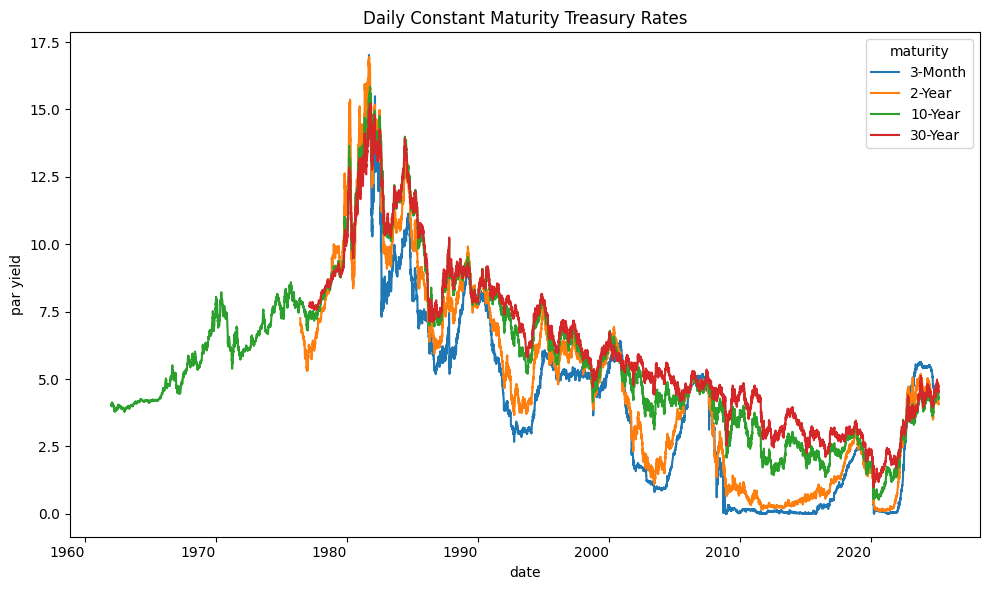

In [8]:
cols = [3, 24, 120, 360]
fig, ax = plt.subplots(figsize=(10, 6))
daily[cols].rename(columns=mapper).plot(ax=ax, rot=0)
plt.title('Daily Constant Maturity Treasury Rates')
plt.ylabel('par yield')
plt.tight_layout()

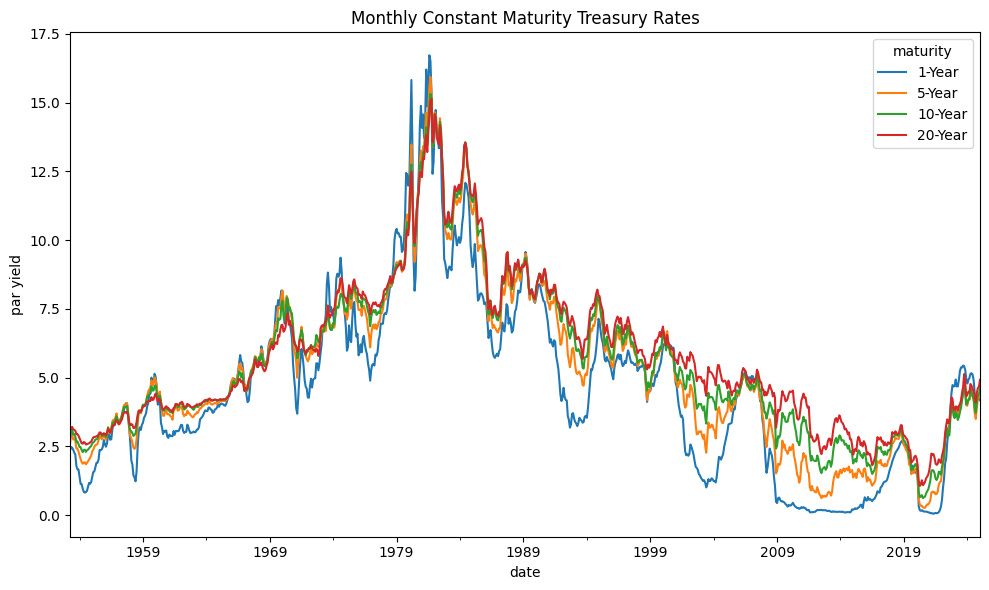

In [9]:
cols = [12, 60, 120, 240]
fig, ax = plt.subplots(figsize=(10, 6))
monthly[cols].rename(columns=mapper).plot(ax=ax, rot=0)
plt.title('Monthly Constant Maturity Treasury Rates')
plt.ylabel('par yield')
plt.tight_layout()

## Yield Curve


  

The U.S. Treasury's official **yield curve** is a par yield curve constructed using a monotone convex method. This curve is based on indicative bid-side price quotations collected by the Federal Reserve Bank of New York at approximately 3:30 PM each trading day.

Historically, the Treasury used a quasi-cubic Hermite spline (HS) method to construct the yield curve. This approach interpolated yields directly from observed market data under the assumption that the resulting curve was a par yield curve. However, since December 6, 2021, the monotone convex method has been the standard.

**Constant Maturity Treasury (CMT) yields** are derived from the Treasury’s par yield curve and represent bond-equivalent yields for semiannual interest-paying securities. These yields are expressed on a simple annualized basis rather than an effective annual yield (APY) basis, which incorporates compounding effects. To convert a CMT yield to APY, use:

$$
APY = \left(1 + \frac{y}{2} \right)^2 - 1
$$


### Splines


Spline interpolation is used to estimate yields at maturities not directly observed in the market. A **piecewise cubic polynomial** ensures smooth transitions between maturities and maintains twice continuous differentiability.


In [10]:
yield_curve = dict()
curve_dates = sorted(daily.dropna().index[-1:0:-(5*252)])
for date in curve_dates:
    yield_curve[date] = CubicSpline(
        x=daily.columns.to_list(), y=daily.loc[date].values, bc_type='clamped')

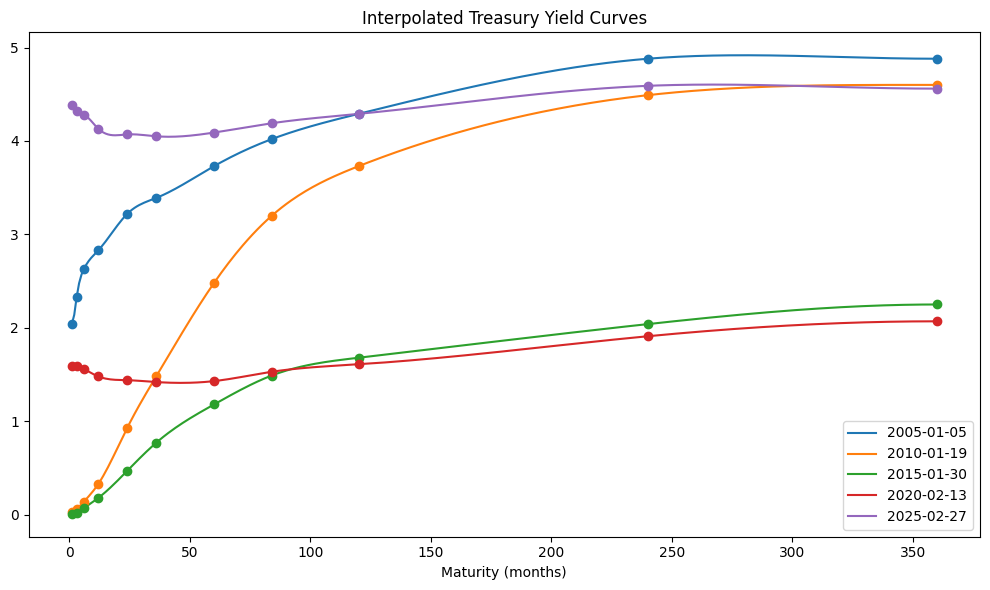

In [11]:
# Plot historical yield curves
fig, ax = plt.subplots(figsize=(10, 6))
X = list(range(1, 361))
for col, (date, curve) in enumerate(yield_curve.items()):
    ax.plot(X, curve(X), label=date.strftime('%Y-%m-%d'), color=f"C{col}")
plt.legend()
for col, (date, curve) in enumerate(yield_curve.items()):
    daily.loc[date].plot(ax=ax, marker='o', ls='', color=f"C{col}", label=None)
plt.title('Interpolated Treasury Yield Curves')
plt.xlabel('Maturity (months)')
plt.tight_layout()

### Bootstrap Method

Bootstrapping is a process used to derive spot rates by progressively solving for zero-coupon rates using available bond data. This iterative approach fits spot rates to increasingly longer maturities.  

In [12]:
# To bootstrap 6-month spot rates from 6-month par yields
m = 2   # compounding periods per year

In [13]:
# list of 6-monthly maturities
maturities = list(range(int(12/m), daily.columns[-1]+1, int(12/m)))

In [14]:
# Helper to bootstrap spot rates from par yield curve
def bootstrap_spot(coupon: float, spots: List[float], m: int, price: float=1) -> float:
    """Compute spot rate to maturity of par bond from yield and sequence of spots

    Args:
      coupon : Annual coupon rate
      spots : Simple annual spot rates each period (excluding last period before maturity
      m : Number of compounding periods per year
      price: Present value of bond

    Returns:
      Simple spot interest rate till maturity
    """
    if not spots:           # trivial one-period bond
        return coupon / price
    n = len(spots) + 1      # number of coupons through maturity

    # discount factors from given spot rates
    discount = [(1 + spot/m)**(-(1+t)) for t, spot in enumerate(spots)]

    # nominal amount of last payment
    last_payment = 1 + coupon/m
    
    # infer present value of last coupon and principal
    last_pv = price - np.sum(discount) * coupon/m 

    # compute discount factor and annualize the effective rate
    spot = ((last_payment/last_pv)**(1/n) - 1) * m
    return spot

In [15]:
# select most recent yield curve
curve_date = curve_dates[-1]
yields = [yield_curve[curve_date](t) / 100 for t in maturities]
spots = []
for coupon in yields:
    spots.append(bootstrap_spot(coupon=coupon, spots=spots, m=m))
DataFrame({curve_date.strftime('%Y-%m%d'): spots}, index=maturities).head()

,2025-0227
6,0.042800
12,0.041285
18,0.040591
24,0.040684
30,0.040639


Helper to compute bond prices

In [16]:
def bond_price(coupon: float, n: int, m: int, yields: float | List[float],
               par: float = 1) -> float:
    """Compute present value of bond given spot rates or yield-to-maturity

    Args:
      coupon : Annual coupon rate
      n : Number of remaining coupons
      m : Number of compounding periods per year
      yields : Simple annual yield-to-maturity or spot rates each period
      par : face or par value of bond

    Returns:
      Present value of bond
    """
    if not pd.api.types.is_list_like(yields):
        yields = [yields] * n        # same yield-to-maturity is spot rate every period
    assert len(yields) == n, "Number of yields must equal number of couponds"
    pv = [(1 + yields[t-1]/m)**(-t) * (coupon/m + (par if t == n else 0))
          for t in range(1, n+1)]    # discount every period's payment, plus last face
    return np.sum(pv)

In [17]:
# Sanity-check par bond price given spots
for t in range(len(yields)):
    price = bond_price(coupon=yields[t], n=t+1, m=2, yields=spots[:(t+1)])
    assert np.allclose(price, 1.0)   # discounted payments at spot rates must equal price

In [18]:
# Compute forward rates from spot rates
def forwards_from_spots(spots: List[float], m: int, skip: int=0) -> List[float]:
    """Compute forward rates given spot rates

    Args:
      spots : Sequence of simple annual spot rates
      m : Number of compounding periods per year
      skip: Number of initial periods skipped

    Returns:
      List of forward rates, excluding first period of spot rates input
    """
    result = []
    assert len(spots) >= 2, "Require at least two spot rates as input"
    for t in range(1, len(spots)):
        n = skip + t
        numerator = (1 + spots[n]/m)**n         # discounted value of period n
        denominator = (1 + spots[n-1]/m)**(n-1)   # discounter value of period n-1
        result.append(((numerator / denominator) - 1) * m)
    return result

In [19]:
forwards = [spots[0]] + forwards_from_spots(spots=spots, m=m)

Plot current yield curve

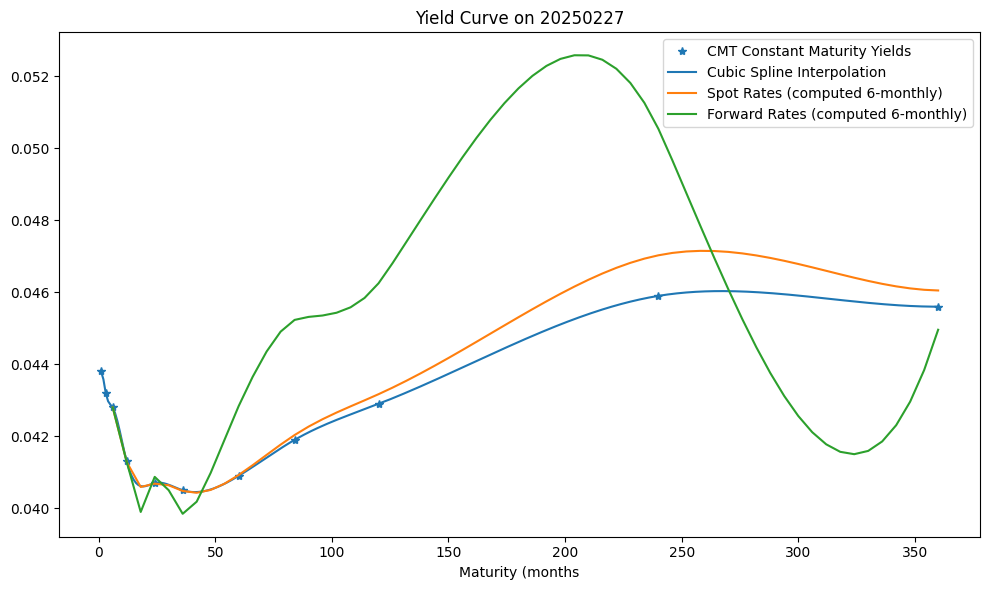

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
(daily.loc[curve_date] / 100).plot(marker='*', ls='', color="C0")
X = range(1, maturities[-1]+1)
ax.plot(X, [yield_curve[curve_date](t) / 100 for t in X], marker='', ls='-', color="C0")
ax.plot(maturities, spots, marker='', ls='-', color="C1")
ax.plot(maturities, forwards, marker='', ls='-', color="C2")
plt.legend(['CMT Constant Maturity Yields', 'Cubic Spline Interpolation',
            'Spot Rates (computed 6-monthly)', 'Forward Rates (computed 6-monthly)'])
plt.title(f"Yield Curve on {curve_date.strftime('%Y%m%d')}")
plt.xlabel('Maturity (months')
plt.tight_layout()

There are more sophisticated methods for fitting yield curves to treasuries prices, such as this model by Liu and Wu (2021)


In [22]:
# Download reconstructed yield curve data by Liu and Wu (2021)
# file_id from https://sites.google.com/view/jingcynthiawu/yield-data
file_id = '1-wmStGZHLx55dSYi3gQK2vb3F8dMw_Nb'   # monthly
#file_id = '11HsxLl_u2tBNt3FyN5iXGsIKLwxvVz7t'  # daily
src = "https://drive.google.com/uc?export=download&id={}".format(file_id) # to load from gdrive
df = pd.ExcelFile(src).parse()
dates = np.where(df.iloc[:, 0].astype(str).str[0].str.isdigit())[0] # locate first date cell

In [23]:
liuwu = DataFrame(np.exp(df.iloc[dates,1:361].astype(float).values/100) - 1,
                  index=(pd.to_datetime(df.iloc[dates, 0], format="%Y%m")
                         + pd.offsets.MonthEnd(1)),
                  columns=np.arange(1, 361))

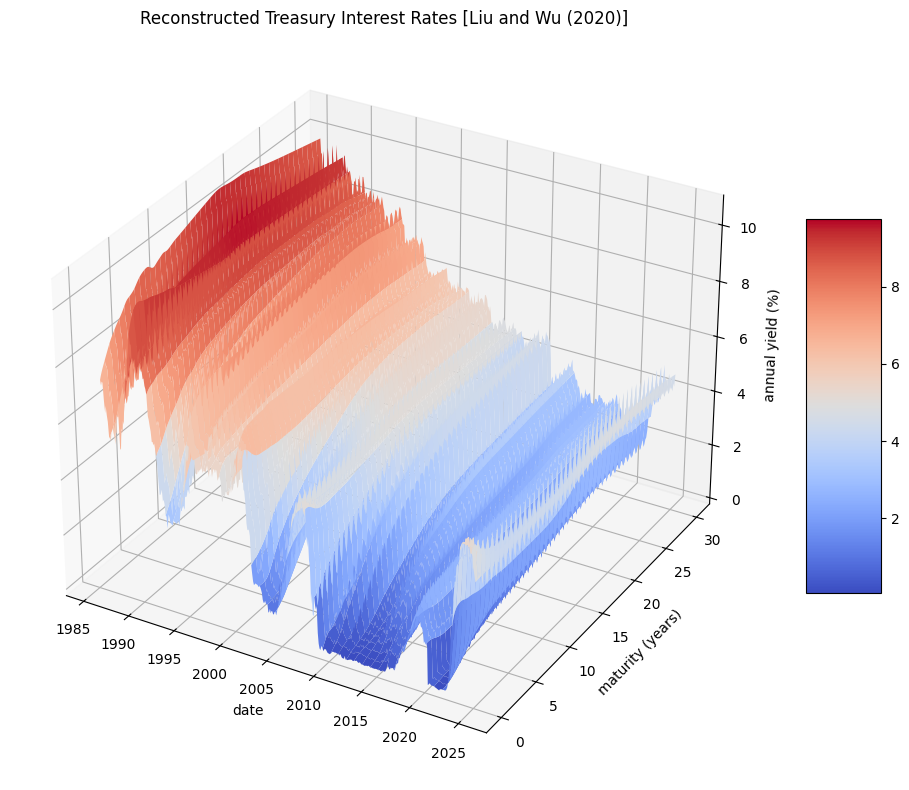

In [24]:
# Plot historical reconstructed rates as 3D surface
from mpl_toolkits.mplot3d import Axes3D
r = liuwu.dropna()
X, Y = np.meshgrid(r.index.map(lambda x: float(str(x)[:4]) + float(str(x)[5:7])/12),
                   r.columns.astype(float)/12)
#X, Y = np.meshgrid((r.index//10000) + ((((r.index//100)%100)-1)/12),
#                   r.columns.astype(float)/12)
Z = r.T.to_numpy()*100
fig = plt.figure(num=1, clear=True, figsize=(10, 8))
ax = plt.axes(projection='3d')
f = ax.plot_surface(X, Y, Z, cmap='coolwarm', linewidth=0, antialiased=True)
ax.set_title('Reconstructed Treasury Interest Rates [Liu and Wu (2020)]')
ax.set_xlabel('date')
ax.set_ylabel('maturity (years)')
ax.set_zlabel('annual yield (%)')
fig.colorbar(f, shrink=0.5, aspect=5)
plt.tight_layout()

In [25]:
# Plot historical Yield Curves
curve_dates = sorted(liuwu.index[-1:0:-(7*12)])[-4:]
for date in curve_dates:
    yield_curve[date] = CubicSpline(
        x=monthly.columns.to_list(), y=monthly.loc[date].values, bc_type='clamped')

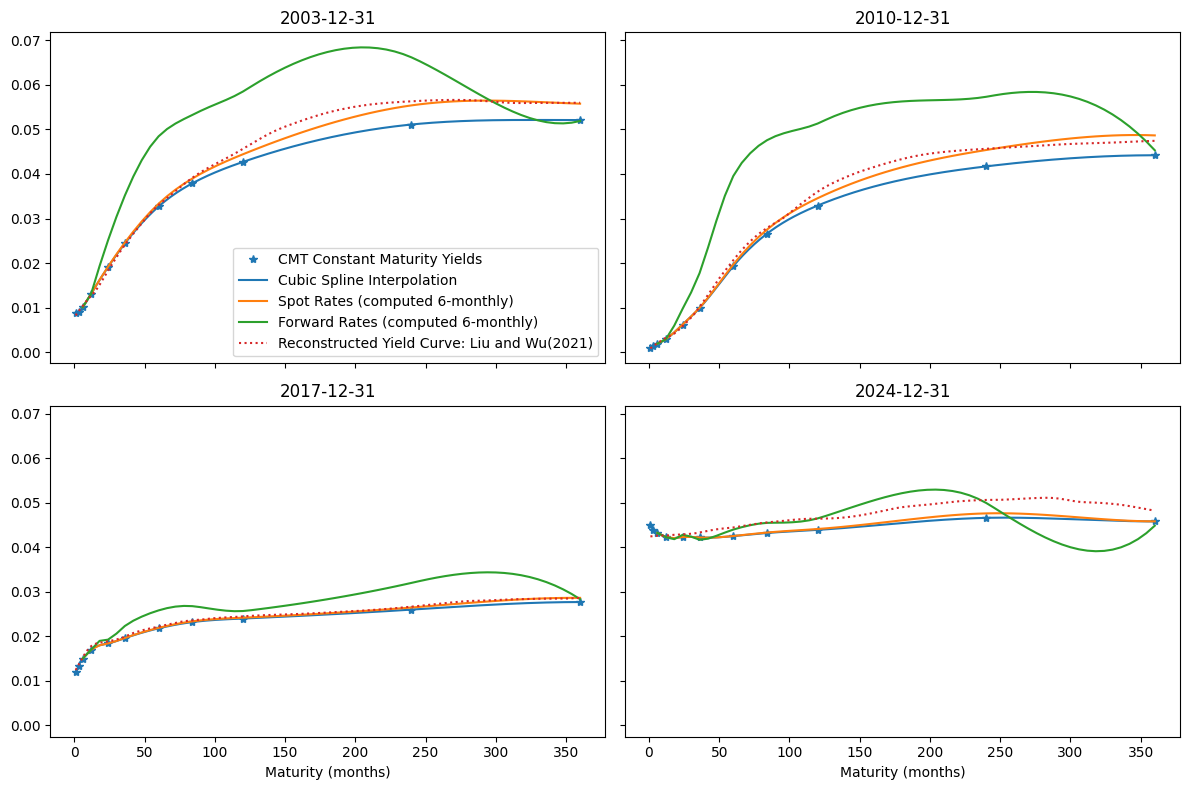

In [26]:
fig, axes = plt.subplots(2,2, figsize=(12, 8), sharey=True, sharex=True)
axes = axes.flatten()
for num, (curve_date, ax) in enumerate(zip(curve_dates, axes)):
    # fit yields
    yields = [yield_curve[curve_date](t) / 100 for t in maturities]

    # compute spots
    spots = []
    for coupon in yields:
        spots.append(bootstrap_spot(coupon=coupon, spots=spots, m=m))

    # compute forwards
    forwards = [spots[0]] + forwards_from_spots(spots=spots, m=m)    

    # plot
    (monthly.loc[curve_date] / 100).plot(marker='*', ls='', color="C0", ax=ax) # CMT yield
    X = range(1, maturities[-1]+1)
    ax.plot(X, [yield_curve[curve_date](t) / 100 for t in X], marker='', ls='-', color="C0")
    ax.plot(maturities, spots, marker='', ls='-', color="C1")
    ax.plot(maturities, forwards, marker='', ls='-', color="C2")
    liuwu.loc[curve_date].plot(ax=ax, marker='', ls=':', color="C3")   # Liu and Wu
    ax.set_title(f"{curve_date.strftime('%Y-%m-%d')}")
    ax.set_xlabel('Maturity (months)')
    if not num:
        ax.legend(['CMT Constant Maturity Yields', 'Cubic Spline Interpolation',
                   'Spot Rates (computed 6-monthly)', 'Forward Rates (computed 6-monthly)',
                   'Reconstructed Yield Curve: Liu and Wu(2021)'])
plt.tight_layout()

## Principal Component Analysis (PCA)

**Principal Component Analysis (PCA)**, also referred to as **eigendecomposition**, involves rotating the data space so that each axis captures the maximum variance. We apply PCA to identify the key factors influencing daily interest rate in Constant Maturity Treasury (CMT) rates.  

The number of factors in PCA equals the number of interest rate maturities analyzed. The first principal component accounts for 84% of daily yield variance, while the first two components explain almost 99%. The first three components together account for approximately 99.9%, meaning most of the uncertainty in yield changes can be attributed to these factors.



In [27]:
X = daily.dropna()
Y = StandardScaler().fit_transform(X)
pca = PCA().fit(Y)
DataFrame({'Cumulative Variance Explained': pca.explained_variance_ratio_.cumsum()},
           index=[f"PC {c+1}" for c in range(pca.n_components_)])

,Cumulative Variance Explained
PC 1,0.841980
PC 2,0.986916
PC 3,0.997595
PC 4,0.998925
PC 5,0.999401
PC 6,0.999727
PC 7,0.999866
PC 8,0.999929
PC 9,0.999965
PC 10,0.999986


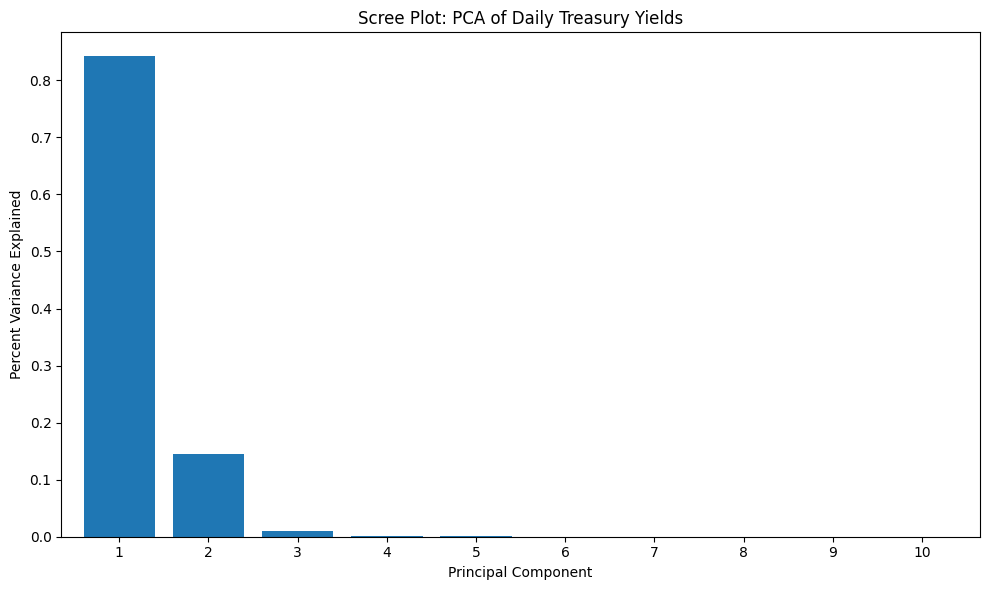

In [28]:
# Scree plot
scree = Series(pca.explained_variance_ratio_, 
               index=np.arange(1, Y.shape[1] + 1))
fig, ax = plt.subplots(figsize=(10, 6))
scree[:10].plot(kind='bar', rot=0, width=.8, ax=ax)
ax.set_title('Scree Plot: PCA of Daily Treasury Yields')
ax.set_ylabel("Percent Variance Explained")
ax.set_xlabel("Principal Component")
plt.tight_layout()

Text(0, 0.5, 'Factor Loading')

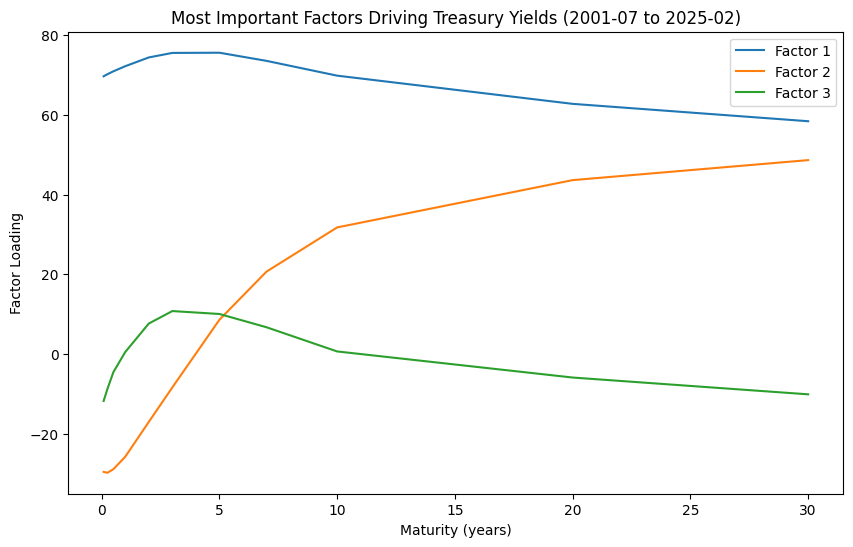

In [40]:
# Factor Loadings
Z = pca.components_[:3, :].T * pca.singular_values_[:3].reshape(1, 3)
loadings = DataFrame(Z, columns=[f"Factor {n+1}" for n in range(3)], index=X.columns/12)
fig, ax = plt.subplots(figsize=(10, 6))
loadings.plot(ax=ax)
ax.set_title(f"Most Important Factors Driving Treasury Yields"
             f" ({str(X.index[0])[:7]} to {str(X.index[-1])[:7]})")
ax.set_xlabel('Maturity (years)')
ax.set_ylabel('Factor Loading')

**Key Factors Affecting Treasury Yields**  

1. **Level Factor** – Represents a parallel shift in yields across all maturities.  
2. **Slope Factor** – Indicates changes in the steepness of the yield curve, where short-term and long-term rates move in opposite directions.  
3. **Twist Factor** – Describes changes in the curvature of the yield curve, where intermediate rates move differently from short- and long-term rates.  


## Singular Value Decomposition (SVD)

**Singular Value Decomposition (SVD)** is a factorization method that decomposes a matrix into three components:

$$
A = U S V^T
$$

where:
- $ U $ and $ V $ are orthogonal matrices representing rotations.
- $ S $ is a diagonal matrix containing singular values (scaling factors).

SVD generalizes eigenvalue decomposition:

$$
A^T A = V \Lambda V^T
$$

where $ \Lambda $ contains the eigenvalues.

A goal of both PCA and SVD is to approximate the original data matrix with a lower-dimensional presentation, with the most important eigen- and singular vectors associated with the largest eigenvalues and singular values respectively.

- **Eigenvalues** ($\lambda$) in PCA correspond to squared singular values in SVD.
- **Principal components** (columns of $ V $) are the **eigenvectors** or **right singular vectors**.
- **Loadings** are obtained by multiplying each principal component by its corresponding singular value.
- **Projections (scores)** are computed by projecting data onto the principal components.

In [41]:
# A is num_samples (N) by num_features (K) data matrix, standardized by column
A = daily.dropna().values
A = (A - A.mean(axis=0)) / A.std(axis=0)  # subtract mean, divide by std
N, K = A.shape
A.shape

(5896, 11)

In [42]:
# svd x is related to pca of x'x
u, s, vT = np.linalg.svd(A, full_matrices=False)
v = vT.T   # transposed right singular vector was returned

The __eigenvalues__ ($\lambda$) of PCA
- can be retrieved as (N-1) times pca.explained_variance_
- are equal to the squares of the singular values ($s$ from SVD)


In [43]:
# s**2 = lambda = N * explained_variance
assert np.allclose((N-1) * pca.explained_variance_, s**2), 'eigenvalues values'
assert np.allclose(pca.singular_values_, s), "singular values"

The __components__  (columns of $V$) of an eigendecomposition
- are also called the __eigenvectors__, or right __singular vectors__ from the SVD
- can be retrieved from the rows of pca.components_, or
- are the rows of $V^T$ (identically, the columns of $V$ from SVD)

Relatedly:
- __loadings__ are computed by multiplying each component by its
  corresponding singular value $v \cdot s$


In [44]:
# components and right singular vectors are identical up to sign flip
for pc in range(K):
    assert (np.allclose(vT[pc, :], pca.components_[pc, :]) or
            np.allclose(vT[pc, :], -pca.components_[pc, :]))

In [45]:
# square of loadings is same as square of data matrix, i.e. the covariance matrix
loadings = np.diag(pca.singular_values_) @ pca.components_
assert np.allclose(A.T @ A, loadings.T @ loadings), 'square matrix'

The __projections__ of PCA
- are also known as the __scores__ or __co-ordinates__
- are computed by projecting the data matrix on the components $A \cdot V$
- or by scaling each left singular vector by its corresponding singular value $u \cdot s$
- can be retrieved by calling pca.transform() on the data matrix


In [46]:
# assert: x @ v == transform(x) (aka projection on components)
y = pca.transform(A)
for pc in range(K):
    assert np.allclose((A@v)[:,pc], -y[:,pc]) or np.allclose((A@v)[:,pc], y[:,pc])
    assert np.allclose(u[:,pc]*s[pc], -y[:,pc]) or np.allclose(u[:,pc]*s[pc], y[:,pc])

## Low-Rank Approximations

PCA and SVD allow approximating the original data matrix with a lower-dimensional representation. 
A rank-k approximation is a technique find a matrix $A_k$​ with lower rank $k$ that is as close as possible to the original matrix $A$ in terms of some measure, typically the Frobenius norm. This approximation reduces the complexity of the data while retaining its most important features. 

### Low-rank approximation by PCA

$$A \approx A_k'A_k = V_{[:k]} D_{[:k]} V_{[:k]}'$$


In [47]:
ATA = A.T.dot(A)
eigval, eigvec = (N-1)*pca.explained_variance_, pca.components_.T
assert np.allclose(eigvec.dot(np.diag(eigval)).dot(eigvec.T), ATA), "pca error"

In [48]:
print('rank-K PCA approximation:')
DataFrame.from_dict({k: (la.norm(
    eigvec[:, :k].dot(np.diag(eigval[:k])).dot(eigvec[:, :k].T) - ATA)/la.norm(ATA)) 
    for k in range(1, 5)}, orient='index', columns=['Frobenius Norm'])\
    .rename_axis(index='K')

rank-K PCA approximation:


,Frobenius Norm
K,
1,0.170097
2,0.012614
3,0.001707
4,0.000700


### Low-rank approximation by SVD

$A \approx A_k = U_{[:k]} S_{[:k]} V_{[:k]}'$


In [49]:
assert np.allclose(u.dot(np.diag(s)).dot(v.T), A), "svd error"

In [50]:
print('rank-K SVD approximation:')
DataFrame.from_dict({k: la.norm(
    u[:, :k].dot(np.diag(s[:k])).dot(v[:, :k].T) - A) / la.norm(A)
    for k in range(1, 5)}, orient='index', columns=['Frobenius Norm'])\
    .rename_axis(index='K')

rank-K SVD approximation:


,Frobenius Norm
K,
1,0.397517
2,0.114383
3,0.049039
4,0.032781


**References:**

FRM Part 1 Exam Book Valuation and Risk Models, Chapter 12-13

Yan Liu and Jing Cynthia Wu "Reconstructing the Yield Curve", Journal of Financial Economics, 2021, 142 (3), 1395-1425. 

https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/treasury-yield-curve-methodology
